# Работа с полученными данными и обучение модели классификации

## 1. Визуализация и анализ данных

Важно: данный датасет уже был предварительно проанализирован и обработан на предыдущем шаге, поэтому в этом ноутбуке мало времени подготовке данных.</br> 
</br>
Немного информации про датасет.</br>
Датасет содержит данные о грузоперевозках, выгруженных с сайта ati.su. Необходимо почистить данные от лишней информации и позже обучить модель, которая будет классифицировать данные по нужным категориям.</br>
Колонки датасета содержат следующую информацию:</br>
• Transport - вид транспорта, необходимый для погрузки</br>
• Link - ссылка на перевозку</br>
• number_of_cargo - информация о номере груза в системе АТИ</br>
• distance_km - расстояние между точками погрузки и выгрузки</br>
• nds - стоимость перевозки с НДС</br>
• request_price - информация о том, является ли доступной информация о стоимости перевозки</br>
• start_city - точка погрузки</br>
• end_city - точка выгрузки</br>
• start_date - дата погрузки</br>
• new_info - контакты с заказчиком и номер телефона</br>
• cargo - сам груз и его габариты</br>
• benifit - целевая переменная, которая разделяет перевозки на 3 категории</br>
</br>
Обозначения меток категорий:</br>
0 - информация о цене недоступна, оценка невозможно</br>
1 - стоимость перевозки слишком низкая</br>
2 - стоимость перевозки подходит под наши параметры поиска

In [4]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier
import joblib

In [5]:
df = pd.read_csv('full_test_data.csv')
df.head(3)

,Transport,Link,number_of_cargo,distance_km,nds,request_price,start_city,end_city,start_date,new_info,cargo,benifit
0,тент. изотермтентованный изотермическийзагр/вы...,https://loads.ati.su/loadinfo/2797902d-74eb-44...,#QMH227265,821,90000,0.0,Новосибирск,Красноярск,готов 5 апр.,"(['ТК БЕЛУН, ООО'], ['+7(383)2768562', '+7(913...","['20 / 90', 'ТНП']",1
1,закр.+терм.все закр.+изотермзагр/выгр:задн.зад...,https://loads.ati.su/loadinfo/6bfd35cc-43e6-4c...,#BOK119951,821,80000,0.0,Новосибирск,Красноярск,готов 29 мар.,"(['ТРАНС-МИССИЯ, ООО'], ['+7992340-16-67'])","['15 / 82', 'ТНП']",1
2,"тент.тентованныйзагр/выгр:верх. 2-бокверхняя, ...",https://loads.ati.su/loadinfo/d6e50b3f-e3ef-44...,#ZFG6868,821,85000,0.0,Новосибирск,Красноярск,готов 26-27 мар.,"([], [])","['10 / 82', 'ТНПДxШ,м:13,6x2,48']",1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Transport        1660 non-null   object 
 1   Link             1660 non-null   object 
 2   number_of_cargo  1660 non-null   object 
 3   distance_km      1660 non-null   int64  
 4   nds              1660 non-null   int64  
 5   request_price    1660 non-null   float64
 6   start_city       1660 non-null   object 
 7   end_city         1660 non-null   object 
 8   start_date       1569 non-null   object 
 9   new_info         1660 non-null   object 
 10  cargo            1660 non-null   object 
 11  benifit          1660 non-null   int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 155.8+ KB


#### Посмотрим на график распределения классов

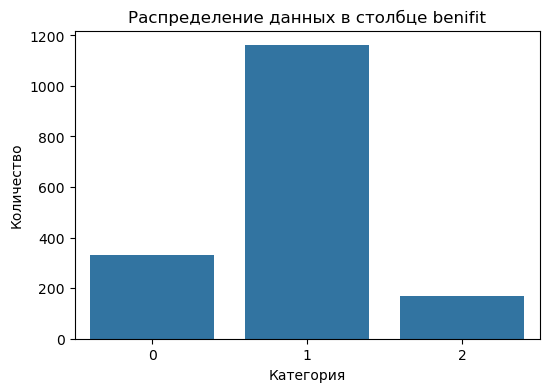

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='benifit', data=df)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.title('Распределение данных в столбце benifit')
plt.show()

#### Посмотрим на график распределения стоимости перевозок

<Axes: xlabel='nds', ylabel='Count'>

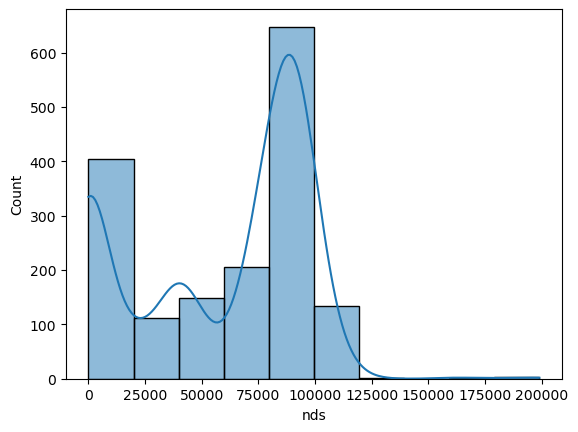

In [11]:
sns.histplot(data=df, x='nds', kde=True, bins=10)

#### Посмотрим на график распределения расстояний перевозок

<Axes: xlabel='distance_km', ylabel='Count'>

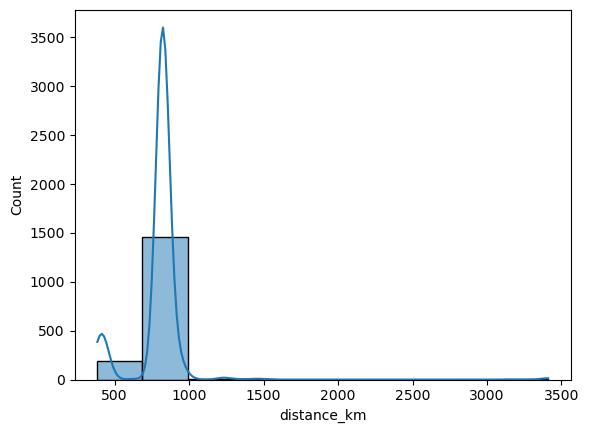

In [16]:
sns.histplot(data=df, x='distance_km', kde=True, bins=10)

#### Проверим уникальность элементов

In [20]:
df['number_of_cargo'].value_counts()

number_of_cargo
#ZEY36436      2
#VEB16382      2
#KRU115168     2
#QIP274077     2
#LUH3290942    2
              ..
#KKC16548      1
#ZKD55675      1
#SJK1362       1
#TMU44041      1
#VVM201055     1
Name: count, Length: 1539, dtype: int64

#### Удалим повторяющиеся грузы и обновим индексацию

In [23]:
df = df.drop_duplicates(subset='number_of_cargo', ignore_index=True)
df.shape

(1539, 12)

#### Исследуем на пропуски

In [26]:
df.isnull().sum().sort_values(ascending=False)

start_date         79
Transport           0
Link                0
number_of_cargo     0
distance_km         0
nds                 0
request_price       0
start_city          0
end_city            0
new_info            0
cargo               0
benifit             0
dtype: int64

#### Посмотрим на моду для каждого столбца

In [29]:
modes = df.mode().iloc[0]
modes

Transport          закр.+терм.все закр.+изотермзагр/выгр:задн.зад...
Link               https://loads.ati.su/loadinfo/e0512a46-621c-4c...
number_of_cargo                                             #ABF2901
distance_km                                                    821.0
nds                                                              0.0
request_price                                                    0.0
start_city                                               Новосибирск
end_city                                                  Красноярск
start_date                                             готов 19 апр.
new_info                                                    ([], [])
cargo                              ['Информация о грузе не найдена']
benifit                                                          1.0
Name: 0, dtype: object

In [31]:
df['number_of_cargo'].value_counts(dropna=False)

number_of_cargo
#QMH227265     1
#IMD9242       1
#KTF35567      1
#YIE211732     1
#VVM192171     1
              ..
#IAU36536      1
#QYP1450882    1
#JHX490037     1
#JEL158900     1
#VVM201055     1
Name: count, Length: 1539, dtype: int64

In [33]:
df = df.drop_duplicates(subset='number_of_cargo', ignore_index=True)
df.head(3)

,Transport,Link,number_of_cargo,distance_km,nds,request_price,start_city,end_city,start_date,new_info,cargo,benifit
0,тент. изотермтентованный изотермическийзагр/вы...,https://loads.ati.su/loadinfo/2797902d-74eb-44...,#QMH227265,821,90000,0.0,Новосибирск,Красноярск,готов 5 апр.,"(['ТК БЕЛУН, ООО'], ['+7(383)2768562', '+7(913...","['20 / 90', 'ТНП']",1
1,закр.+терм.все закр.+изотермзагр/выгр:задн.зад...,https://loads.ati.su/loadinfo/6bfd35cc-43e6-4c...,#BOK119951,821,80000,0.0,Новосибирск,Красноярск,готов 29 мар.,"(['ТРАНС-МИССИЯ, ООО'], ['+7992340-16-67'])","['15 / 82', 'ТНП']",1
2,"тент.тентованныйзагр/выгр:верх. 2-бокверхняя, ...",https://loads.ati.su/loadinfo/d6e50b3f-e3ef-44...,#ZFG6868,821,85000,0.0,Новосибирск,Красноярск,готов 26-27 мар.,"([], [])","['10 / 82', 'ТНПДxШ,м:13,6x2,48']",1


In [35]:
df.shape

(1539, 12)

#### Основная задача - уловить зависимости, которые существуют между маршрутами и стоимостью перевозок. Среди имеющихся столбцов некоторые не содержат полезной для обучения модели информацию, поэтому удалим их:
1. Link, number_of_cargo просто представляют из себя уникальные идентификаторы для грузов. Из них нельзя получить никакой полезной информации, так как они различны для всех элементов датасета.
2. Transport содержит информацию только о том, какой тип кузова нужен для осуществления перевозки (предварительно в фильтрах сайта были выбраны только те автомобили, которые есть в автопарке транспортной компании, поэтому особого смысла в этом параметре нет).
3. start_date - это просто дата погрузки. Парсер не собирает информацию о том, когда перевозка была выложена, поэтому уловить какие-то зависимости между ценой и срочностью не получится.  
4. request_price коррелирует со столбцом nds, поэтому если его не удалить, то он приведет к переобучению.

#### Также есть интересные параметры, которые можно будет распарсить для более детального изучения, но делать это хочется только если точность модели без них будет недостаточно высокой. (да и есть вопросы к качеству разметки, поэтому не факт, что удастся извлечь из них какую-то полезную информацию)
1. new_info содержит информацию о заказчике и его контакты, поэтому можно предположить, что есть заказчики, которые стабильно выкладывают перевозки с хорошей ставкой (также наверняка могут быть заказчики, которые наоборот специально занижают стоимость перевозок).
2. cargo - столбец с информацией о том, какой груз и в каком объеме необходимо перевезти. Этот столбец может содержать полезную информацию, так как может быть выгодно собирать маленькие перевозки в один большой сборный груз. Возможно также есть какая-то корреляция между стоимостью груза и стоимостью перевозки.

In [38]:
df = df.drop(['Link', 'number_of_cargo', 'new_info', 'Transport', 'start_date', 'request_price', 'cargo'], axis=1)
df.head(3)

,distance_km,nds,start_city,end_city,benifit
0,821,90000,Новосибирск,Красноярск,1
1,821,80000,Новосибирск,Красноярск,1
2,821,85000,Новосибирск,Красноярск,1


#### Проверим данные на наличие выбросов

In [41]:
print(f"Минимальное расстояние между точками погрузки и выгрузки: {df['distance_km'].min()} км.")
print(f"Среднее расстояние между точками погрузки и выгрузки: {(df['distance_km'].mean()).round(2)} км.")
print(f"Максимальное расстояние между точками погрузки и выгрузки: {df['distance_km'].max()} км.\n")

print(f"Минимальная стоимость перевозки: {df[df['nds'] > 0]['nds'].min()} руб.")
print(f"Минимальная стоимость перевозки: {df[df['nds'] > 1]['nds'].min()} руб.")
print(f"Средняя стоимость перевозки: {(df[df['nds'] > 0]['nds'].mean()).round(2)} км.")
print(f"Максимальная стоимость перевозки: {df['nds'].max()} руб.")

Минимальное расстояние между точками погрузки и выгрузки: 384 км.
Среднее расстояние между точками погрузки и выгрузки: 795.74 км.
Максимальное расстояние между точками погрузки и выгрузки: 3411 км.

Минимальная стоимость перевозки: 1 руб.
Минимальная стоимость перевозки: 3000 руб.
Средняя стоимость перевозки: 74228.21 км.
Максимальная стоимость перевозки: 199000 руб.


#### В наборе данных присутствуют перевозки с объявленной стоимостью в 1 рубль. Я считаю, что такие грузы либо являются ошибкой, либо попыткой заказчика найти наиболее выгодное предложение путём аукциона. В любом случае такие перевозки не очень информативны и могут путать модель, поэтому нужно их удалить.

In [44]:
df = df[df['nds'] != 1]
df.head(3)

,distance_km,nds,start_city,end_city,benifit
0,821,90000,Новосибирск,Красноярск,1
1,821,80000,Новосибирск,Красноярск,1
2,821,85000,Новосибирск,Красноярск,1


In [46]:
df.shape

(1535, 5)

## 2. Обучение моделей

#### Отделим от данных целевую переменную

In [50]:
X = df.drop(['benifit'], axis=1)
y = df['benifit']

In [52]:
X.head(3)

,distance_km,nds,start_city,end_city
0,821,90000,Новосибирск,Красноярск
1,821,80000,Новосибирск,Красноярск
2,821,85000,Новосибирск,Красноярск


#### Переименуем столбцы с информацией о городах погрузки и выгрузки (это нужно из-за того, что в начале сбора данных парсер был немного другой, поэтому столбцы назывались по-другому)

In [55]:
X = X.rename(columns={'start_city': 'start', 'end_city': 'end'})
X.head(3)

,distance_km,nds,start,end
0,821,90000,Новосибирск,Красноярск
1,821,80000,Новосибирск,Красноярск
2,821,85000,Новосибирск,Красноярск


In [57]:
X.shape, y.shape

((1535, 4), (1535,))

#### Закодируем города при помощи техники One-hot encoding

In [60]:
X = pd.get_dummies(X, columns=['start', 'end'])
X.head(3)

,distance_km,nds,start_Абакан,start_Бердск,start_Верх-Тула,start_Красноярск,start_Красный Восток,start_Красный Яр,start_Криводановка,start_Мичуринск,...,end_Емельяново,end_Енисейск,end_Информация недоступна,end_Красноярск,end_Новосибирск,end_Пригорск,end_Солонцы,end_Сосновоборск,end_Черногорск,end_Шуваево
0,821,90000,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,821,80000,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,821,85000,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


#### Разделим датасет на обучающую и тестовую выборки

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 22)

### Логистическая регрессия

In [67]:
log_reg = LogisticRegression(multi_class='multinomial', random_state=22, max_iter=1000)

In [69]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=22)

In [70]:
y_pred = log_reg.predict(X_test)

In [73]:
print(f'Результат модели по метрике accuracy: {round(accuracy_score(y_test, y_pred)*100, 2)}%')
print(f'Результат модели по метрике precision: {round(precision_score(y_test, y_pred, average="weighted")*100, 2)}%')
print(f'Результат модели по метрике recall: {round(recall_score(y_test, y_pred, average="weighted")*100, 2)}%')
print(f'Результат модели по метрике f1-score: {round(f1_score(y_test, y_pred, average="weighted")*100, 2)}%')

Результат модели по метрике accuracy: 98.05%
Результат модели по метрике precision: 98.02%
Результат модели по метрике recall: 98.05%
Результат модели по метрике f1-score: 97.98%


### Случайный лес

In [76]:
rf = RandomForestClassifier(random_state = 22)

rf.fit(X_train, y_train)

rf_y_pred = rf.predict(X_test)

In [78]:
print(f'Результат модели по метрике accuracy: {round(accuracy_score(y_test, rf_y_pred)*100, 2)}%')
print(f'Результат модели по метрике precision: {round(precision_score(y_test, rf_y_pred, average="weighted")*100, 2)}%')
print(f'Результат модели по метрике recall: {round(recall_score(y_test, rf_y_pred, average="weighted")*100, 2)}%')
print(f'Результат модели по метрике f1-score: {round(f1_score(y_test, rf_y_pred, average="weighted")*100, 2)}%')

Результат модели по метрике accuracy: 98.37%
Результат модели по метрике precision: 98.35%
Результат модели по метрике recall: 98.37%
Результат модели по метрике f1-score: 98.33%


### Градиентный бустинг

In [81]:
ctb = CatBoostClassifier(random_seed=22,iterations=150,loss_function='MultiClass')

ctb.fit(X_train, y_train, verbose=False)

ctb_y_pred = ctb.predict(X_test)

In [82]:
print(f'Результат модели по метрике accuracy: {round(accuracy_score(y_test, ctb_y_pred)*100, 2)}%')
print(f'Результат модели по метрике precision: {round(precision_score(y_test, ctb_y_pred, average="weighted")*100, 2)}%')
print(f'Результат модели по метрике recall: {round(recall_score(y_test, ctb_y_pred, average="weighted")*100, 2)}%')
print(f'Результат модели по метрике f1-score: {round(f1_score(y_test, ctb_y_pred, average="weighted")*100, 2)}%')

Результат модели по метрике accuracy: 99.02%
Результат модели по метрике precision: 99.04%
Результат модели по метрике recall: 99.02%
Результат модели по метрике f1-score: 99.0%


### Матрица ошибок

<Axes: >

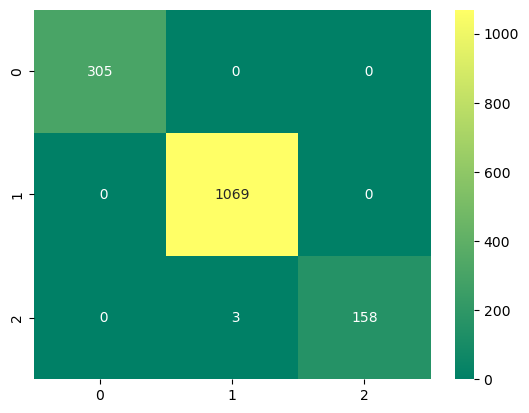

In [86]:
cat_pred = ctb.predict(X)
conf_mat = confusion_matrix(y, cat_pred)
sns.heatmap(conf_mat, annot=True, fmt='3.0f', cmap="summer")

## 3. Итоги

### По итогам проделанной работы можно сделать следующие итоги
1. Лучше всего справился градиентный бустинг. Точность модели составила около 99%.
2. Скорей всего точность получилась такой высокой из-за недостаточно качественной разметки данных (разметкой занимался не я). В дальнейшем можно будет потратить больше времени и ресурсов на разметку для улучшения модели.

### Сохраним модель для дальнейшего использования

In [91]:
joblib.dump(ctb, "model2.pkl")

['model2.pkl']